In [282]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import find_peaks, argrelextrema,argrelmax,argrelmin
import scipy.stats as stats
from scipy.stats import genextreme as gev
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram

from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv
pandas2ri.activate()

extRemes = importr("extRemes")

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [283]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("cma.mplstyle")

In [284]:
from scipy.stats import genextreme as gev
def empirical_return_level(data):
    """
    Compute empirical return level using the algorithm introduced in Tutorial 2
    """
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df["sorted"] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df["ranks_sp"] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df["exceedance"] = df["ranks_sp"] / (n + 1)
    # find return period
    df["period"] = 1 / df["exceedance"]

    df = df[::-1]

    out = xr.DataArray(
        dims=["period"],
        coords={"period": df["period"]},
        data=df["sorted"],
        name="level",
    )
    return out

In [285]:
yearb=1980
yeare=2008

files=[f'../AFI/AFI_ERA5_{iyear}_fullUSA.nc' for iyear in range(yearb,yeare+1)]

ds=xr.open_mfdataset(files)

return_periods=[2, 5, 10, 25, 50, 100]
return_afi=np.zeros((len(return_periods),len(ds.lat),len(ds.lon)))*np.nan
Rmethod=np.zeros((len(ds.lat),len(ds.lon)))*np.nan
Tlon=ds.lon.data
Tlat=ds.lat.data

units='degree-days (°F)'

In [286]:
ptlon=[260,270,264.25,241,205,204]
ptlat=[48,40,37,46.25,68.75,60]

Text(0.5, 0.98, 'AFI mean (1980-2009)')

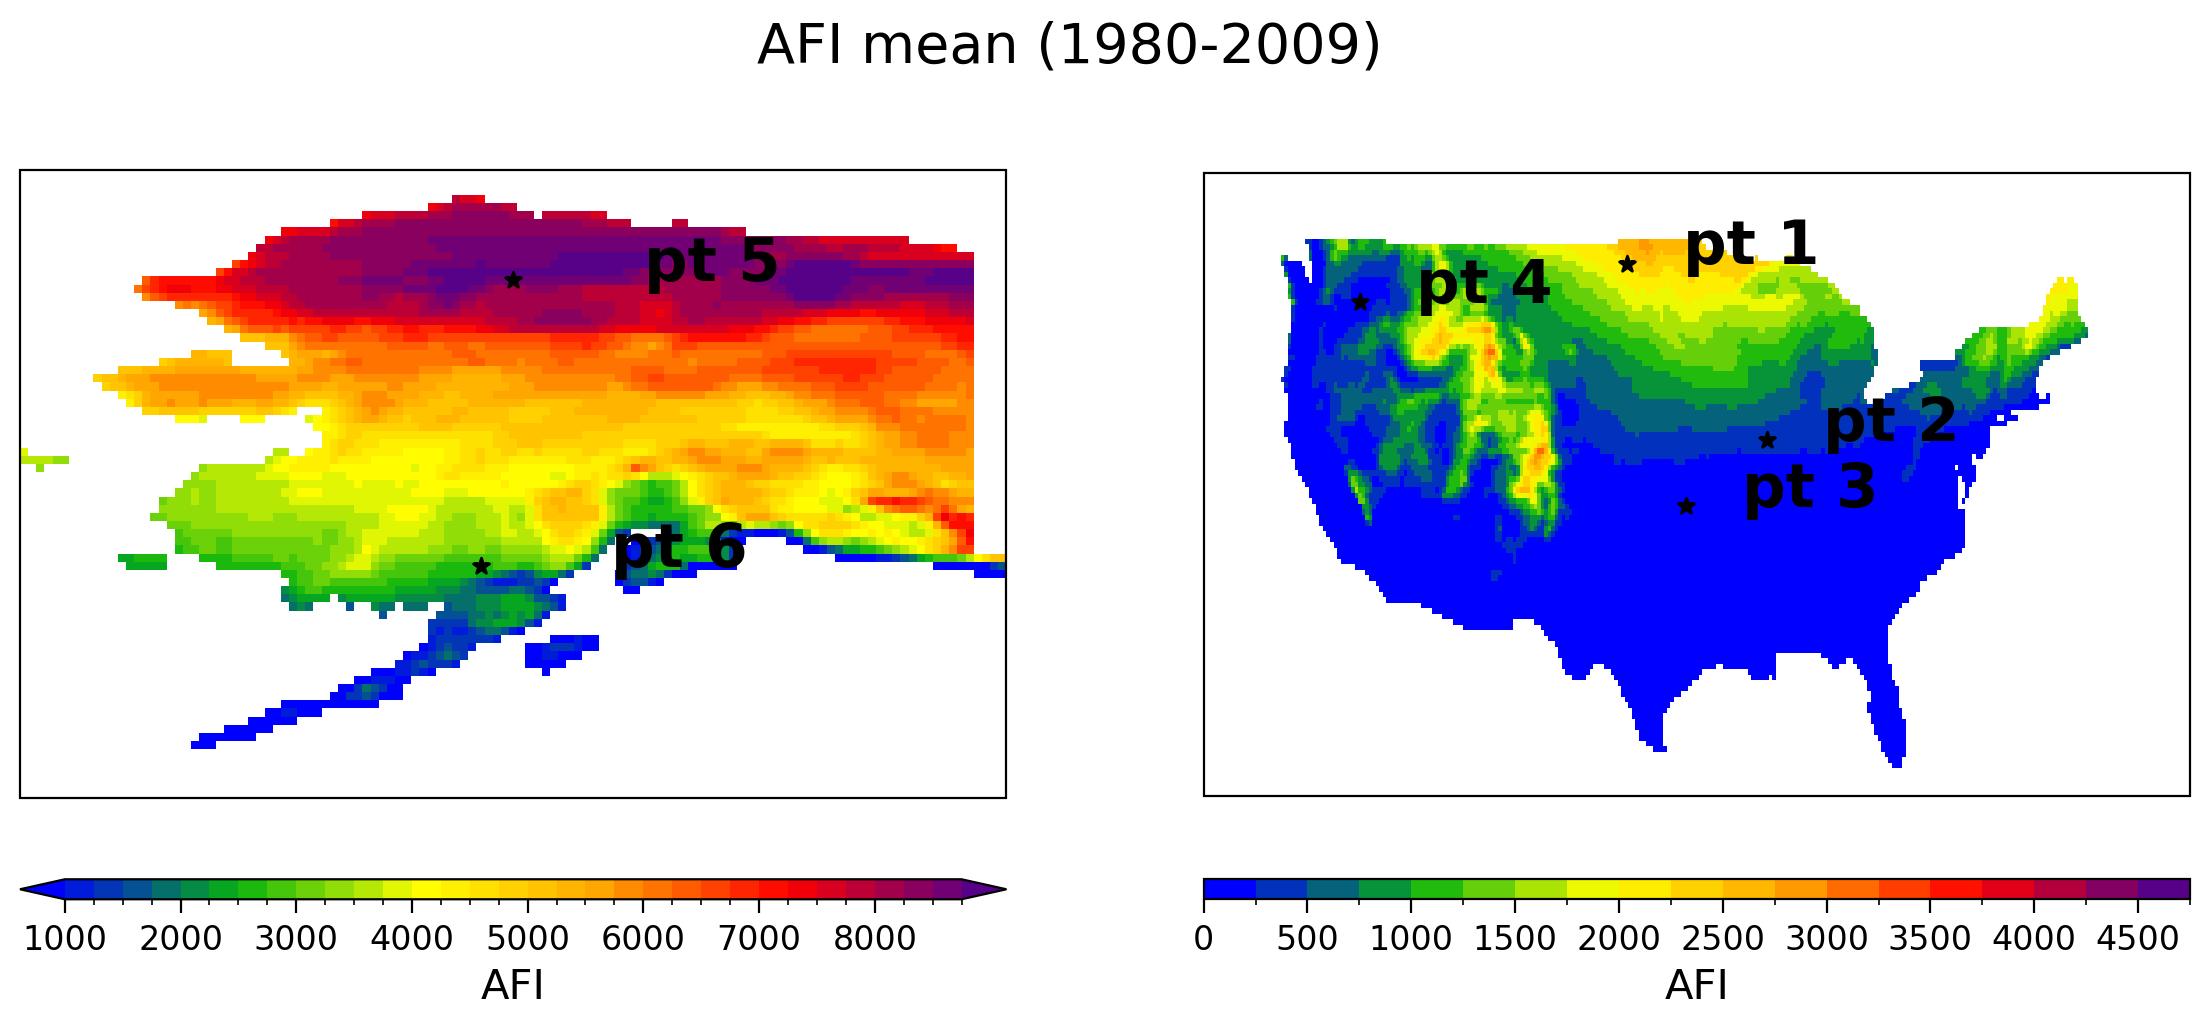

In [287]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

cc=ds['AFI'].where(ds['AFI']>0.).mean('time').sel(lon=slice(190,220),lat=slice(72,53)).plot(ax=ax[0],cmap=cmap,levels=np.arange(1000,9000,250),add_colorbar=False)
for ip in range(4,6):
  ax[0].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[0].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label='AFI')
cbar.ax.tick_params(labelsize=12)

cc=ds['AFI'].where(ds['AFI']>0.).mean('time').sel(lon=slice(230,300),lat=slice(52,22)).plot(ax=ax[1],cmap=cmap,levels=np.arange(0,5000,250),add_colorbar=False)
for ip in range(0,4):
  ax[1].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[1].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label='AFI')
cbar.ax.tick_params(labelsize=12)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)
plt.suptitle('AFI mean (1980-2009)', fontsize=20)

# Pt 1

In [288]:
ij=0
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

In [289]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :1327  ' '1st Qu.:1778  ' 'Median :2328  ' 'Mean   :2276  '
 '3rd Qu.:2633  ' 'Max.   :3439  ' 'Min.   :1980  ' '1st Qu.:1987  '
 'Median :1994  ' 'Mean   :1994  ' '3rd Qu.:2001  ' 'Max.   :2008  ']


Define fit for GEV, Gumbel, Frechet, Weibull

In [290]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb


In [291]:
locGEV,scaleGEV,shapeGEV=fitGEV['results']['par']
locGumb,scaleGumb=fitGumb['results']['par']
globalenv['locGEV'] =locGEV 
globalenv['scaleGEV']=scaleGEV
globalenv['shapeGEV']=shapeGEV
globalenv['locGumb'] =locGumb
globalenv['scaleGumb']=scaleGumb

In [292]:
#%R fpGEV<-plot(fitGEV, type = "rl", main = "Return Level Plot - GEV")
#%R fpGumb<-plot(fitGumb, type = "rl", add = TRUE, col = "red") # Add Gumbel plot with a different color


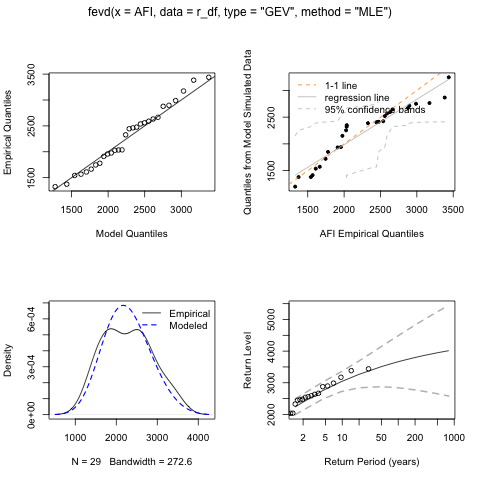

In [293]:
%R plot(fitGEV)

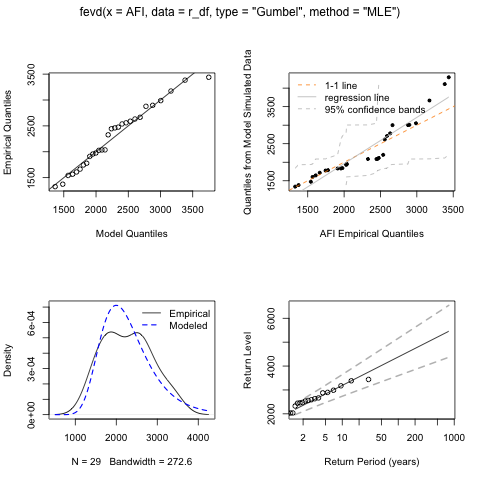

In [294]:
%R plot(fitGumb)

In [295]:
#%R fpGEV<-plot(fitGEV,type='rl')
#%R -o fpGEV 

Extract return_periods

In [296]:
%R return_periods <- c( 2,  5,10, 20, 50, 100, 200,500,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
#%R rlWei<-return.level(fitWei, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/1818875444.py:34: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/1818875444.py:34: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '260$\\degree$E;48$\\degree$N')

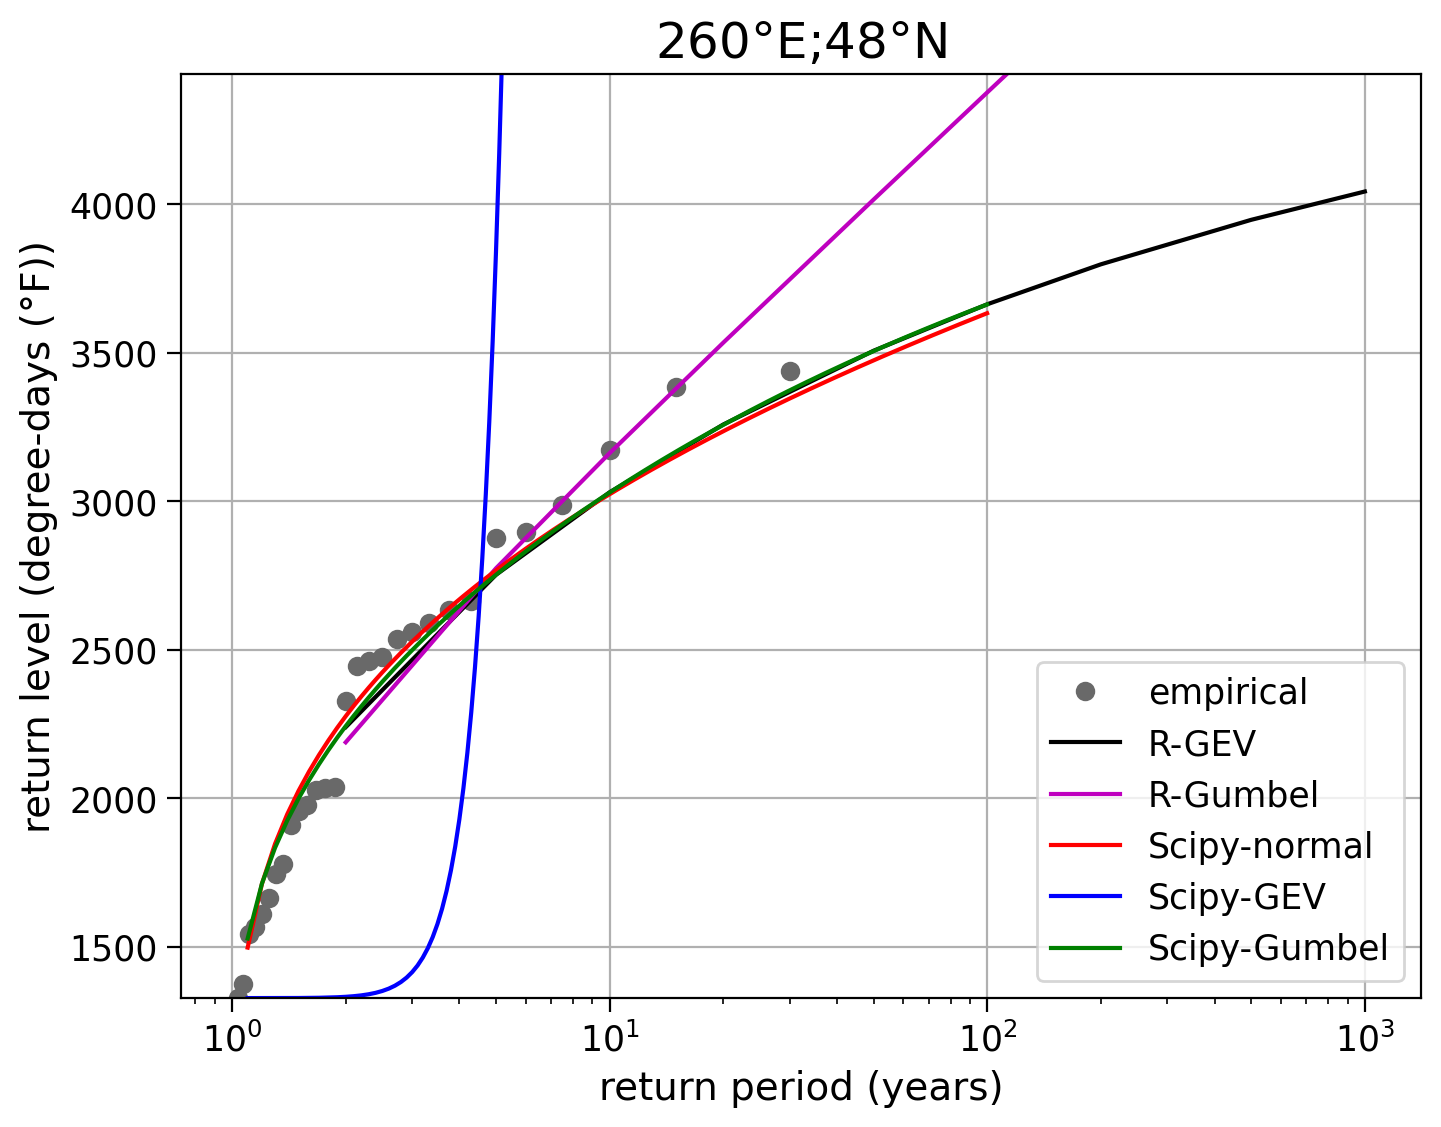

In [297]:
c=[2,  5,10, 20, 50, 100, 200,500,1000]
year=np.arange(1980,2009)
fig, ax = plt.subplots(nrows=1,ncols=1)
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')

# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels

ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),c='r',label=f"Scipy-normal")
# calculate and plot the GEV distribution, note the negtive shape parameter
pgev = gev.fit(nonzero_afis)

ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='b',label=f"Scipy-GEV")

# calculate and plot the Gumbl distribution
pgum = gev.fit(nonzero_afis,0)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"Scipy-Gumbel")

#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

A return level plot of the annual AFI in degree-days (F) versus the return period in years. The smaller the return period, the more data points we have, as these events are more likely. In contrast, events of a 10-year to a 100-year return period are rare in our 103-year-long dataset.

# Pt 2

In [298]:
ij=1
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

In [299]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :  0.6575  ' '1st Qu.:191.3118  ' 'Median :382.7024  '
 'Mean   :348.7907  ' '3rd Qu.:447.3997  ' 'Max.   :887.4810  '
 'Min.   :1980  ' '1st Qu.:1987  ' 'Median :1994  ' 'Mean   :1994  '
 '3rd Qu.:2001  ' 'Max.   :2008  ']


In [300]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb

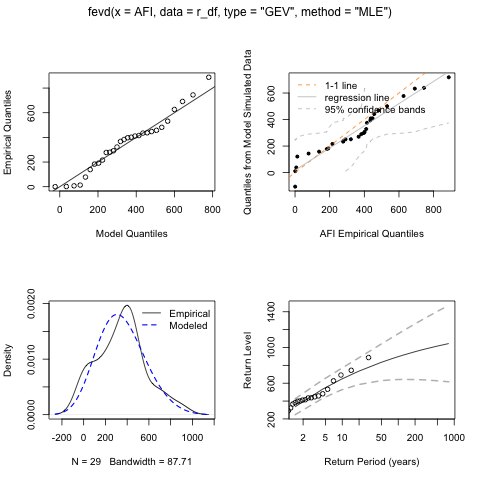

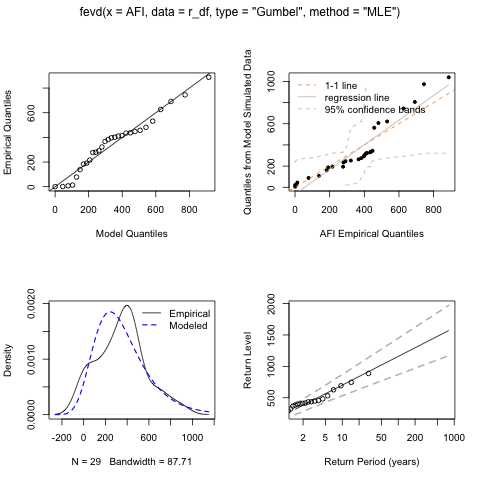

In [301]:
%R plot(fitGEV)
%R plot(fitGumb)

In [302]:
%R return_periods <- c( 2,  5,10, 20, 50, 100, 200,500,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/1813509461.py:33: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/1813509461.py:33: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '270$\\degree$E;40$\\degree$N')

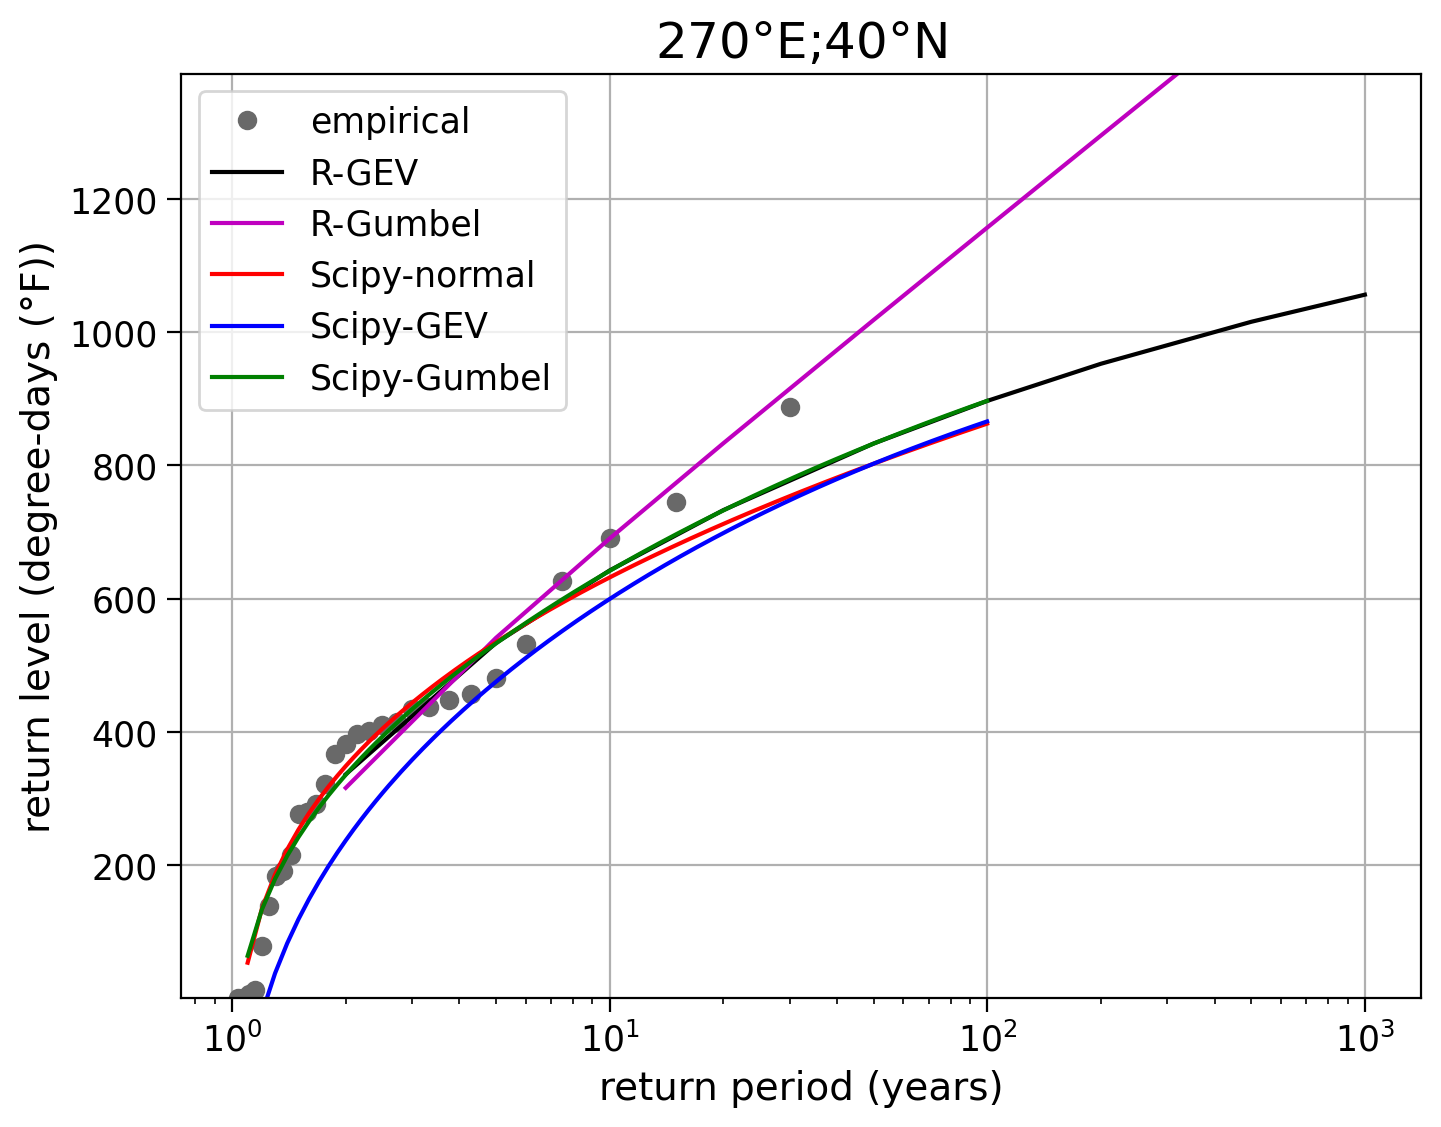

In [303]:
c=[2,  5,10, 20, 50, 100, 200,500,1000]
year=np.arange(1980,2009)
fig, ax = plt.subplots(nrows=1,ncols=1)
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')

# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels

ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),c='r',label=f"Scipy-normal")
# calculate and plot the GEV distribution, note the negtive shape parameter
pgev = gev.fit(nonzero_afis)

ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='b',label=f"Scipy-GEV")

# calculate and plot the Gumbl distribution
pgum = gev.fit(nonzero_afis,0)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"Scipy-Gumbel")
#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+500.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

# Pt 3

In [304]:
ij=2
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :  0.2676  ' '1st Qu.:  2.3877  ' 'Median :  6.4619  '
 'Mean   : 67.9923  ' '3rd Qu.: 70.4429  ' 'Max.   :488.7080  '
 'Min.   :1980  ' '1st Qu.:1987  ' 'Median :1994  ' 'Mean   :1994  '
 '3rd Qu.:2001  ' 'Max.   :2008  ']


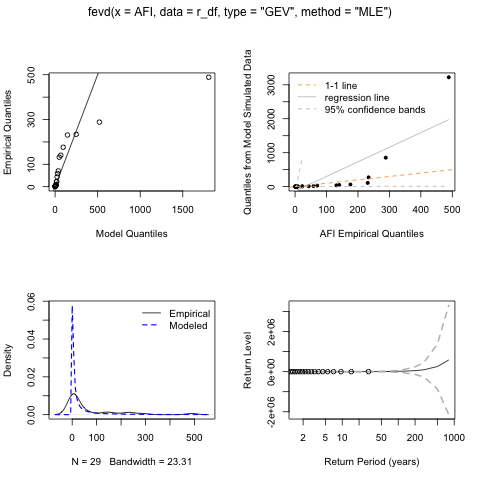

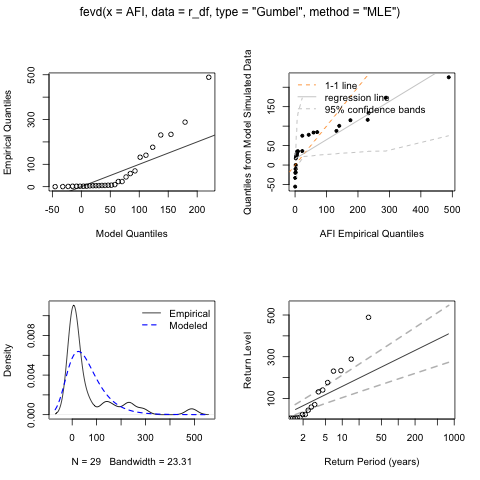

In [305]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb
%R plot(fitGEV)
%R plot(fitGumb)

<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/3891214646.py:38: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/3891214646.py:38: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '264.25$\\degree$E;37$\\degree$N')

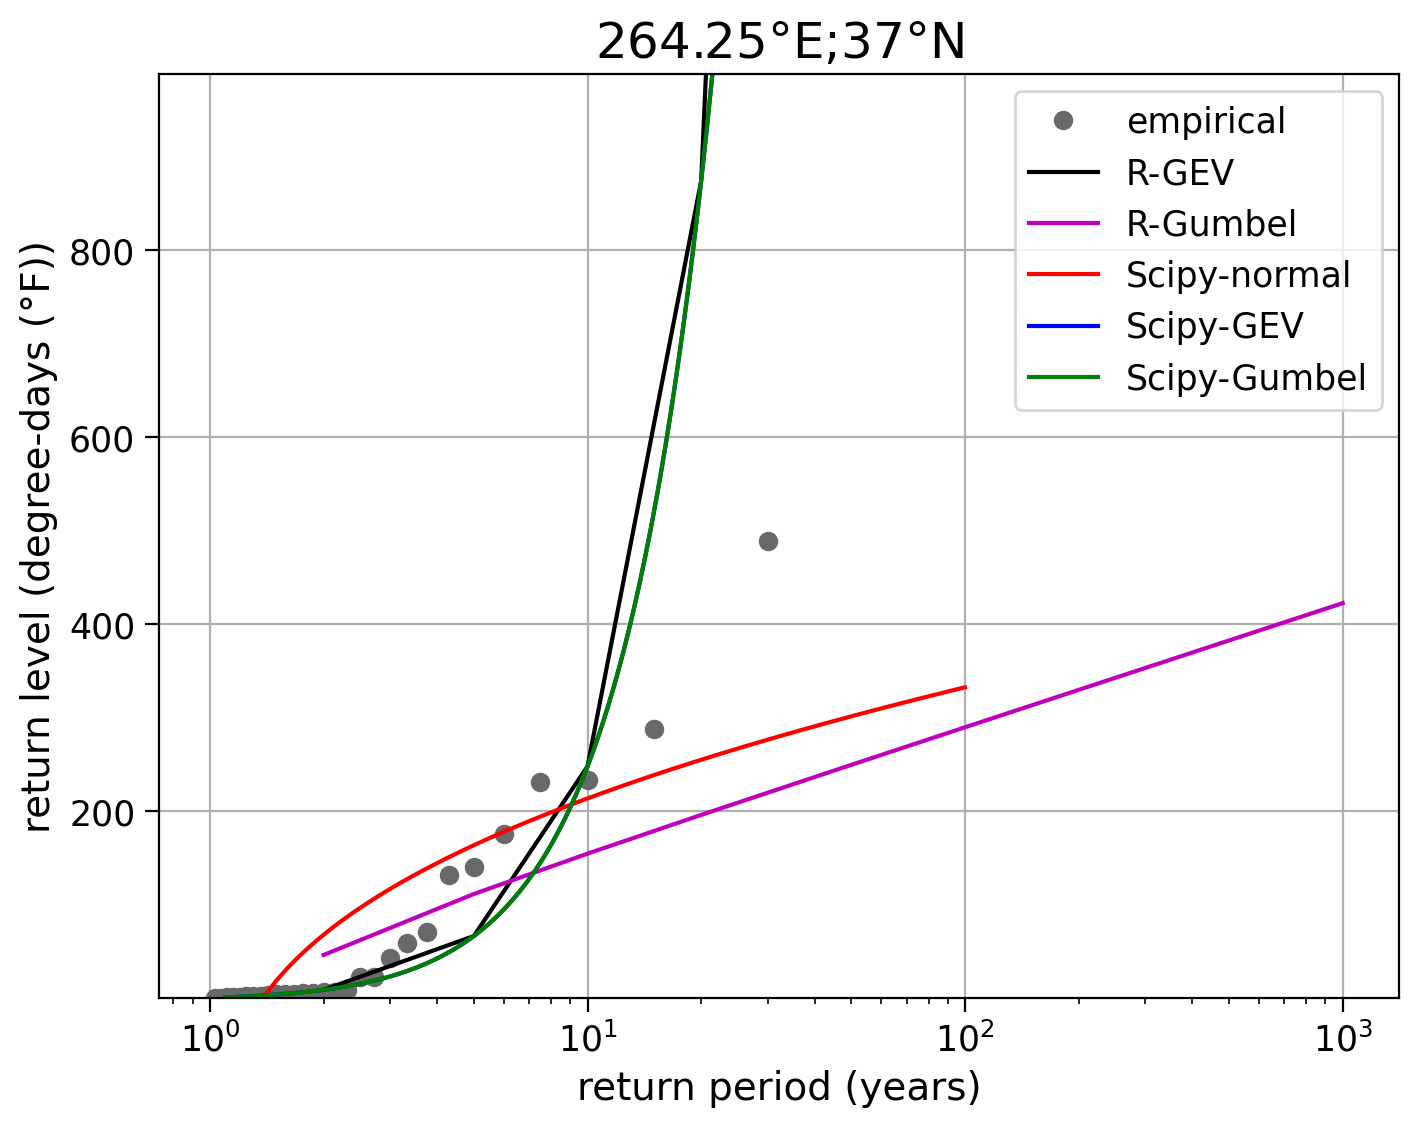

In [306]:
%R return_periods <- c( 2,  5,10, 20, 50, 100, 200,500,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

c=[2,  5,10, 20, 50, 100, 200,500,1000]
year=np.arange(1980,2009)
fig, ax = plt.subplots(nrows=1,ncols=1)
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')

# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels

ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),c='r',label=f"Scipy-normal")
# calculate and plot the GEV distribution, note the negtive shape parameter
pgev = gev.fit(nonzero_afis)

ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='b',label=f"Scipy-GEV")

# calculate and plot the Gumbl distribution
pgum = gev.fit(nonzero_afis,0)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"Scipy-Gumbel")
#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+500.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

# Pt 4

In [307]:
ij=3
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :  0.4282  ' '1st Qu.:  2.3760  ' 'Median : 26.8005  '
 'Mean   :118.7921  ' '3rd Qu.:223.0945  ' 'Max.   :812.9270  '
 'Min.   :1980  ' '1st Qu.:1987  ' 'Median :1994  ' 'Mean   :1994  '
 '3rd Qu.:2001  ' 'Max.   :2008  ']


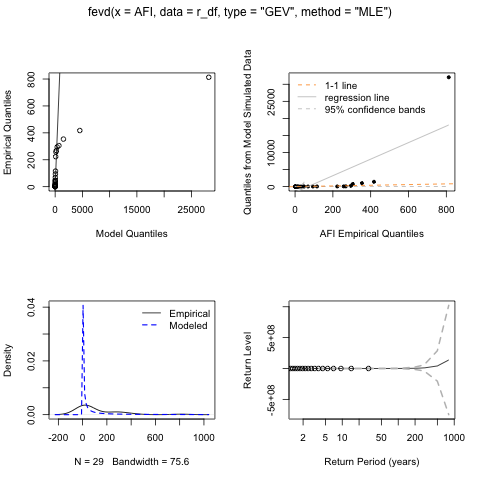

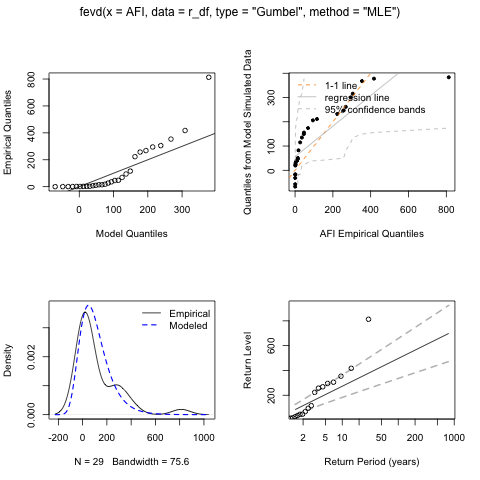

In [308]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb
%R plot(fitGEV)
%R plot(fitGumb)

<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/3891214646.py:38: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/3891214646.py:38: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '241$\\degree$E;46.25$\\degree$N')

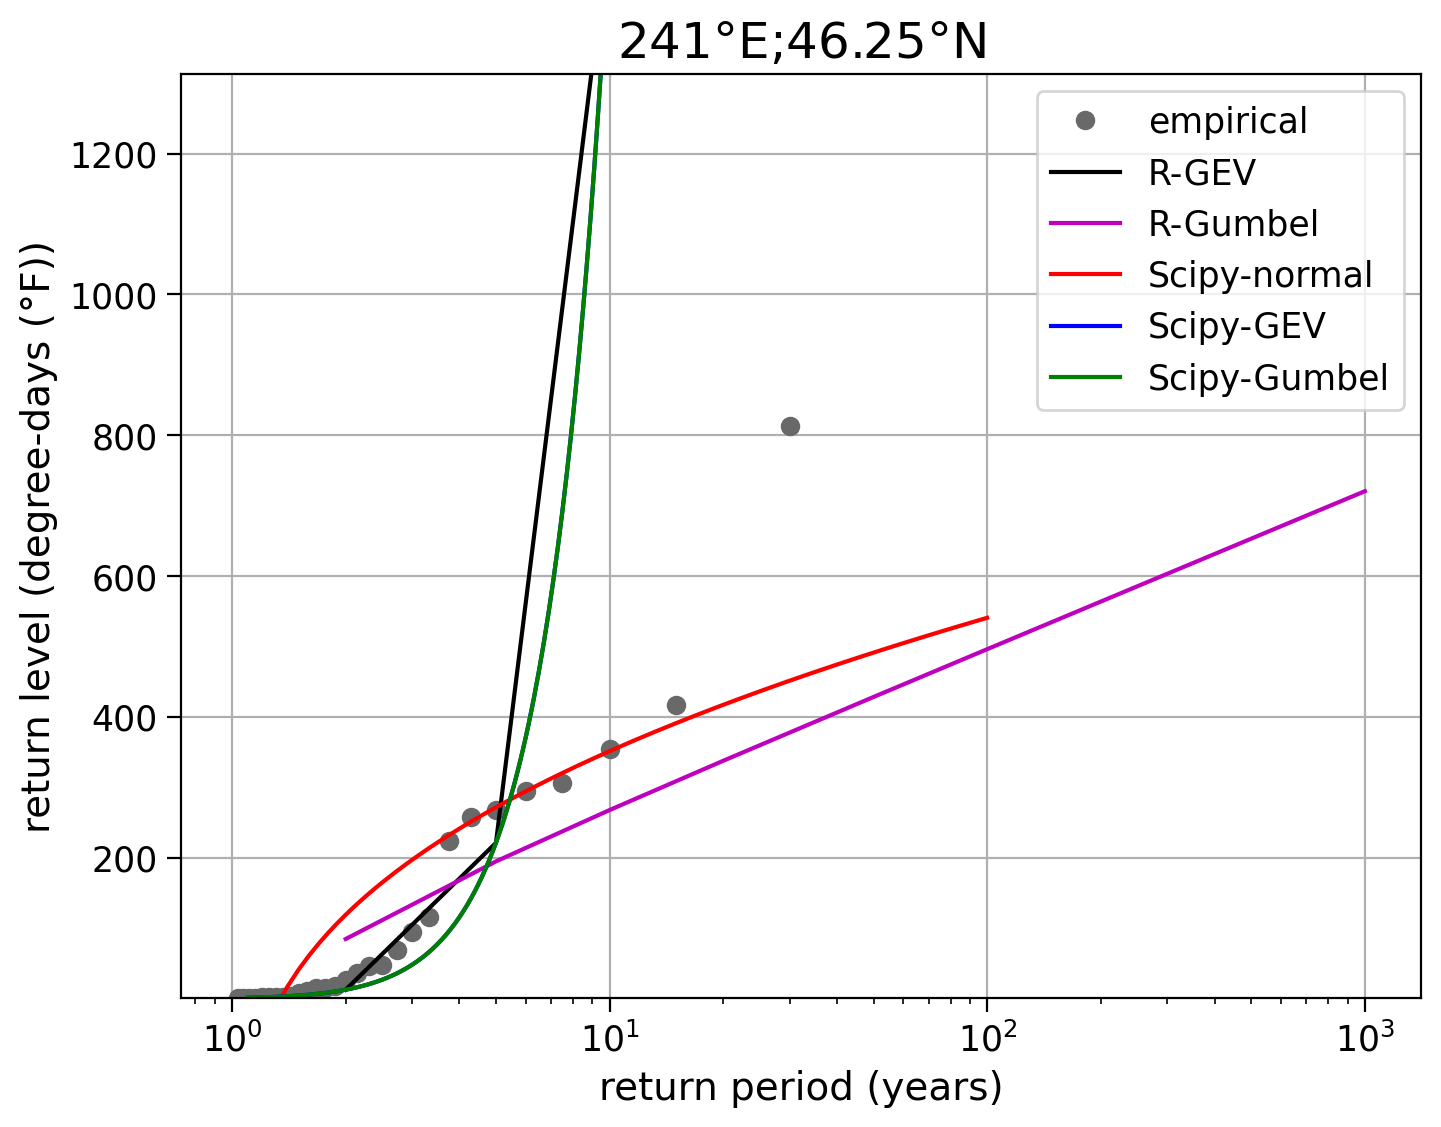

In [309]:
%R return_periods <- c( 2,  5,10, 20, 50, 100, 200,500,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

c=[2,  5,10, 20, 50, 100, 200,500,1000]
year=np.arange(1980,2009)
fig, ax = plt.subplots(nrows=1,ncols=1)
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')

# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels

ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),c='r',label=f"Scipy-normal")
# calculate and plot the GEV distribution, note the negtive shape parameter
pgev = gev.fit(nonzero_afis)

ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='b',label=f"Scipy-GEV")

# calculate and plot the Gumbl distribution
pgum = gev.fit(nonzero_afis,0)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"Scipy-Gumbel")
#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+500.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

# Pt 5

In [310]:
ij=4
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :7280  ' '1st Qu.:8224  ' 'Median :8369  ' 'Mean   :8550  '
 '3rd Qu.:8914  ' 'Max.   :9941  ' 'Min.   :1980  ' '1st Qu.:1987  '
 'Median :1994  ' 'Mean   :1994  ' '3rd Qu.:2001  ' 'Max.   :2008  ']


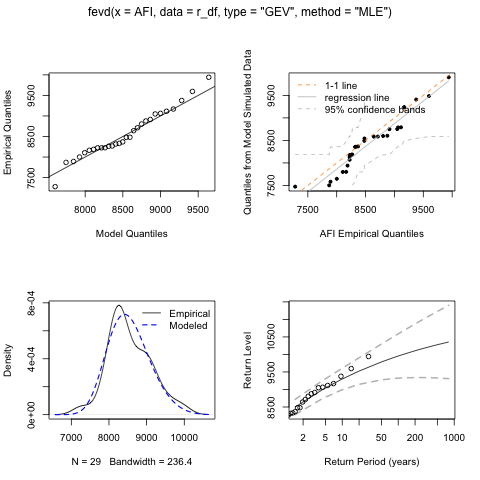

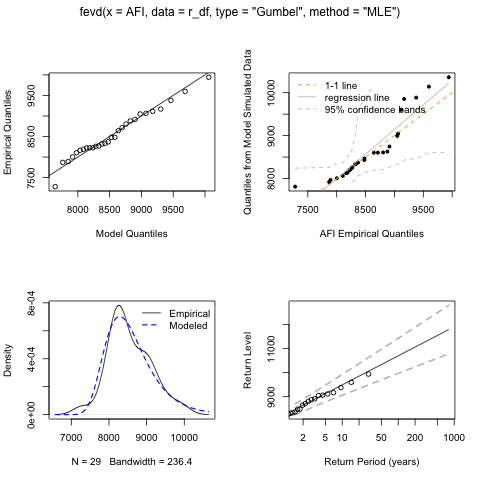

In [311]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb
%R plot(fitGEV)
%R plot(fitGumb)

<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/3186329448.py:33: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/3186329448.py:33: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/3186329448.py:39: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipy

Text(0.5, 1.0, '205$\\degree$E;68.75$\\degree$N')

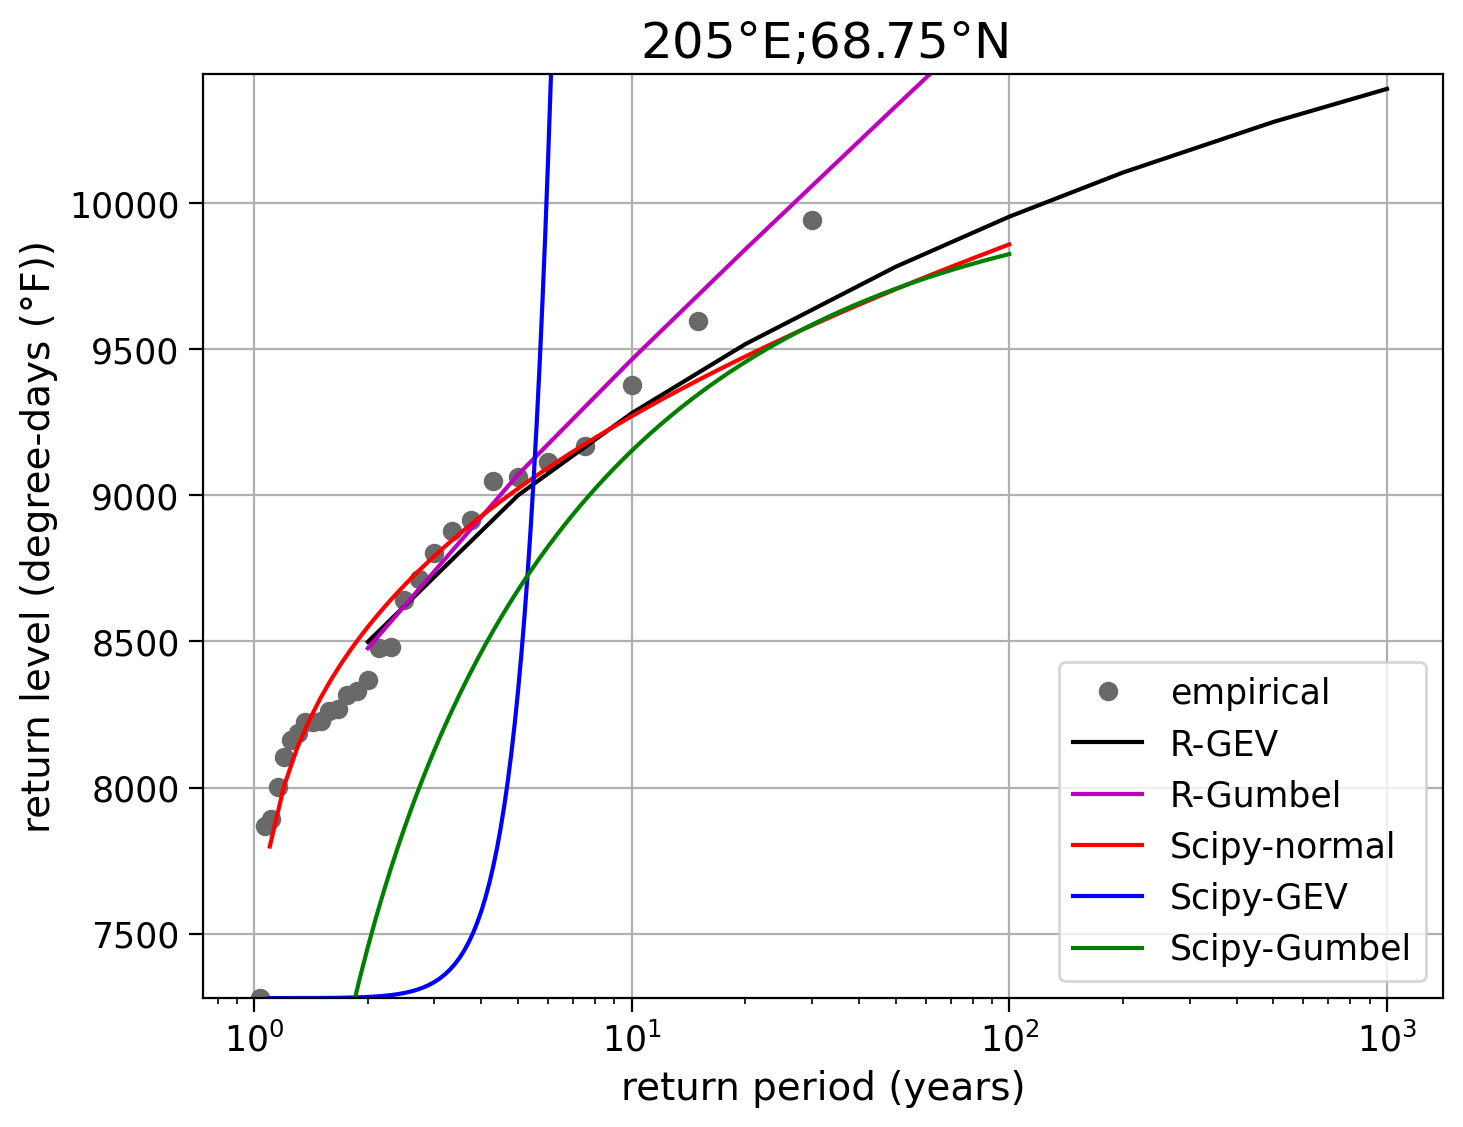

In [312]:
%R return_periods <- c( 2,  5,10, 20, 50, 100, 200,500,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

c=[2,  5,10, 20, 50, 100, 200,500,1000]
year=np.arange(1980,2009)
fig, ax = plt.subplots(nrows=1,ncols=1)
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')

# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels

ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),c='r',label=f"Scipy-normal")
# calculate and plot the GEV distribution, note the negtive shape parameter
pgev = gev.fit(nonzero_afis)

ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='b',label=f"Scipy-GEV")

# calculate and plot the Gumbl distribution
pgum = gev.fit(nonzero_afis,0)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"Scipy-Gumbel")
#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+500.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

# Pt 6

In [313]:
ij=5
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :1042  ' '1st Qu.:2359  ' 'Median :2702  ' 'Mean   :2636  '
 '3rd Qu.:3078  ' 'Max.   :3648  ' 'Min.   :1980  ' '1st Qu.:1987  '
 'Median :1994  ' 'Mean   :1994  ' '3rd Qu.:2001  ' 'Max.   :2008  ']


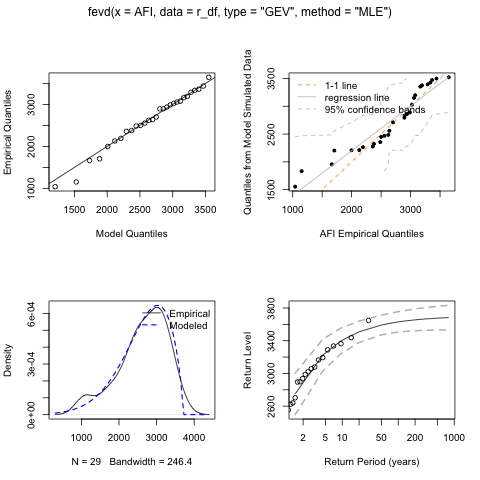

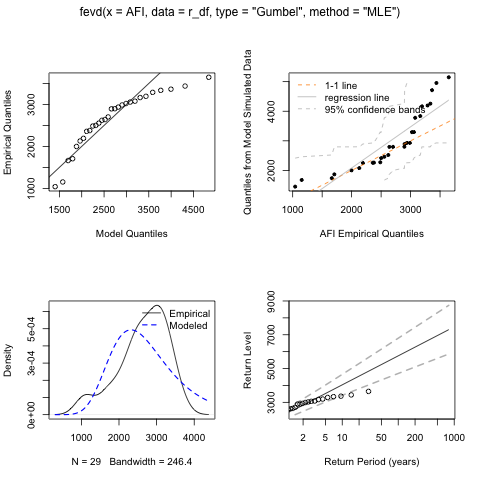

In [314]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb
%R plot(fitGEV)
%R plot(fitGumb)

<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/1414394716.py:39: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_57762/1414394716.py:39: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '204$\\degree$E;60$\\degree$N')

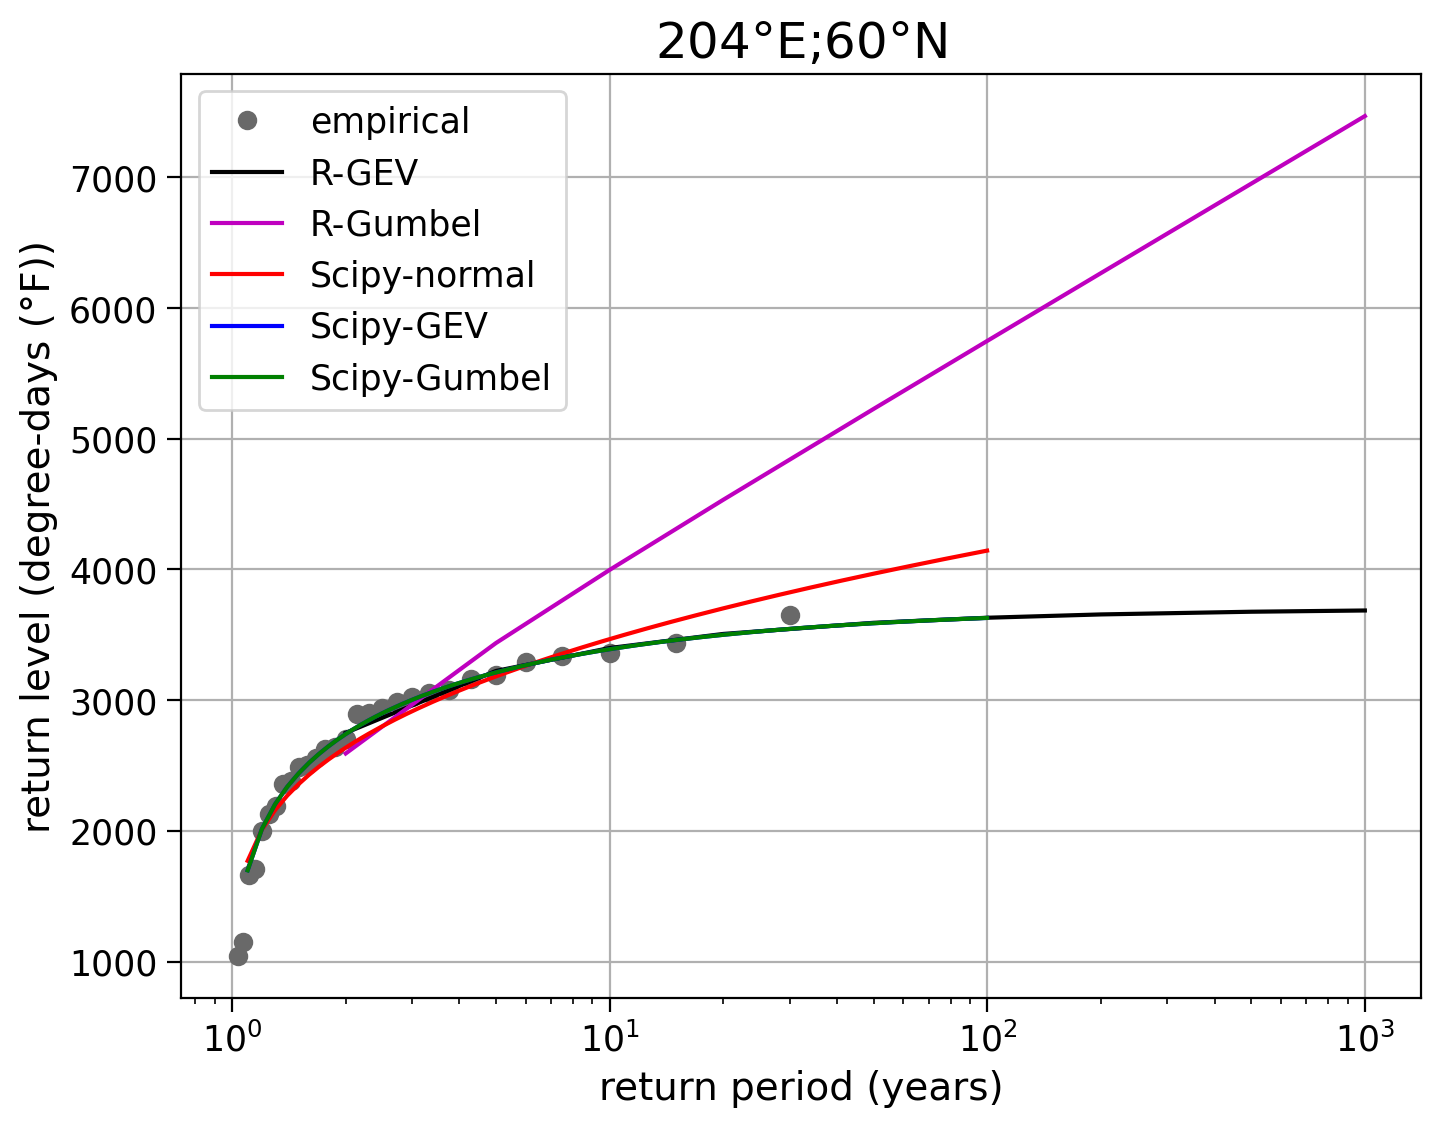

In [315]:
%R return_periods <- c( 2,  5,10, 20, 50, 100, 200,500,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

c=[2,  5,10, 20, 50, 100, 200,500,1000]
year=np.arange(1980,2009)
fig, ax = plt.subplots(nrows=1,ncols=1)
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')

# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels

ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),c='r',label=f"Scipy-normal")
# calculate and plot the GEV distribution, note the negtive shape parameter
pgev = gev.fit(nonzero_afis)

ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='b',label=f"Scipy-GEV")

# calculate and plot the Gumbl distribution
pgum = gev.fit(nonzero_afis,0)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"Scipy-Gumbel")
#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)


ax.grid()
# set y axis lim
#ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+500.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')